# LMfit.jl demonstration

2024_10_15: IBS

This notebook demonstrates the current functionality of the `LMfit.jl` package.  This package is patterned after the wonderful `lmfit` python package; I currently implement only a tiny subset of the features of the original Python version: specifically those features that I use...  As I encounter needed features I will move them over.

In general the syntax is similar enough to `lmfit.py`, but owing to differences between Julia and Python, the interface is not identical. 

## Basic setup

In [5]:
using Pkg
if isfile("Project.toml")
    Pkg.activate(".")
end

using LaTeXStrings # Because of the l"" syntax
using Revise
using CairoMakie
using LMfit

  Activating project at `~/Julia/LMfit/notebooks`


## Direct usage

I am going to start with the most literal possible implementation before introducing convenance features.

We begin by defining an objective function---in this case a simple Gaussian---evaluate the function and generate fake, noisy, data.  Then I plot this to see what we are after.

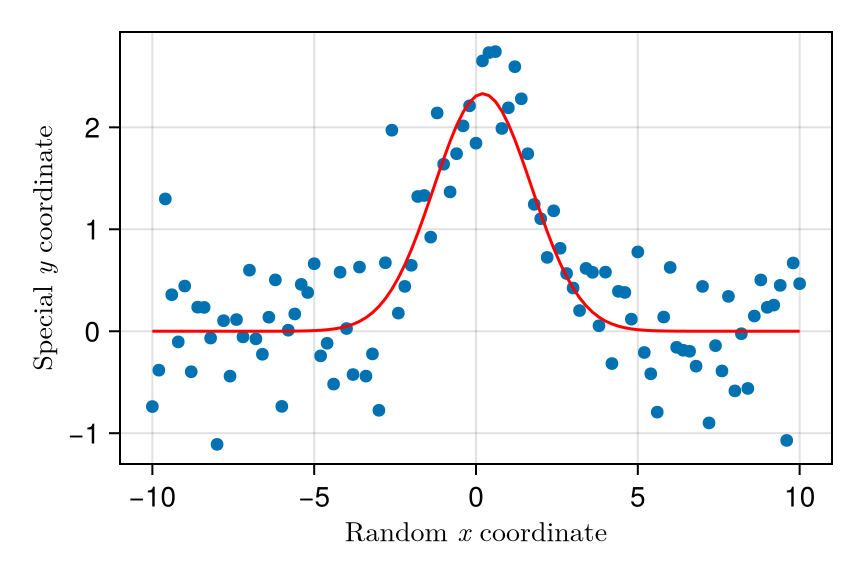

In [24]:
gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))

x = range(-10, 10, length=101)
y = gaussian(x, 2.33, 0.21, 1.51)
y_noise = y .+ 0.5 .* randn(size(x))

f = Figure(size=(6,4).*72)
ax = Axis(f[1,1])
plot!(ax, x, y_noise)
lines!(ax, x, y, color=:red)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Special $y$ coordinate"

f

Now we define a model and the associatd parameters

In [35]:
# We are creating a model from the function.  Because of the multiple dispatch system, we need to 
# manually specifiy what args and kwargs are for the specific method we want to use
m  = Model(gaussian, [:x, :amp, :cen, :wid]; var_names=[:x])

# These are the parameters we want to fit
ps = Parameters()
add!(ps, :amp; value=1.0, min=0.0, max=5.0)
add!(ps, :cen; value=0.0, min=-5.0, max=5.0)
add!(ps, :wid; value=1.0)

# Generate data from the model before and after the fit
ps_fit = fit(m, y_noise, ps; x=x)
y_model = m(ps; x=x)
y_fit = m(ps_fit; x=x)
println("Final parameters: $(ps_fit)")


Final parameters: Parameters:
	Parameter: name=wid,	value=1.5530454547943995,	min=-Inf,	max=Inf
	Parameter: name=amp,	value=2.413633893532101,	min=0.0,	max=5.0
	Parameter: name=cen,	value=0.3389049734344707,	min=-5.0,	max=5.0



Great!  We have setup the model, linked variables, fit the model, and evaluated the model as a function.  The final stage is to plot the results!

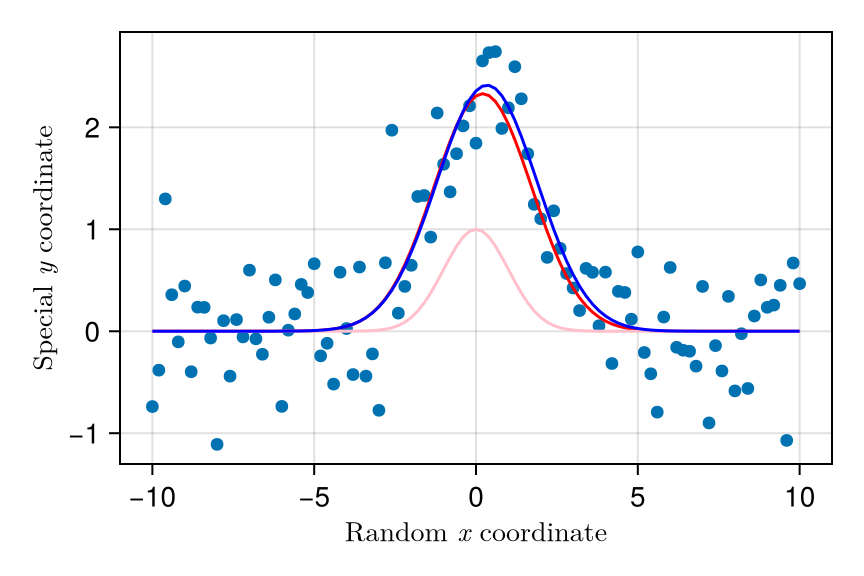

In [36]:
f = Figure(size=(6,4).*72)
ax = Axis(f[1,1])
plot!(ax, x, y_noise)
lines!(ax, x, y, color=:red)
lines!(ax, x, y_model, color=:pink)
lines!(ax, x, y_fit, color=:blue)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Special $y$ coordinate"

f

## Simplified usage

When the function is defined locally, the process can be simplified via the `@generate_model` macro.  This works with the function definition to initialize the model.  Notice that this cannot distinguish parameters from independent variables, so we need to specify the variables.  Once the independent variable is defined we can ask the model to automatically generate parameters, but parameters need to be specified. 

In [179]:
# Define an objective function
m = @generate_model gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))
update_vars!(m, :x)

# Create parameters automatically (very little behefit here except for error checking)
ps = make_params(m; amp=(value=1.0, min=0.0, max=5.0), cen=(value=0.0, min=-5.0, max=5.0), wid=1.0)

# Generate data from model
y_model = m(ps; x=x)

# Generate data from the model before and after the fit
ps_fit = fit(m, y_noise, ps; x=x)
y_model = m(ps; x=x)
y_fit = m(ps_fit; x=x)
println("Final parameters: $(ps_fit)")

Final parameters: Parameters:
	Parameter: name=wid,	value=1.5530454547943995,	min=-Inf,	max=Inf
	Parameter: name=amp,	value=2.413633893532101,	min=0.0,	max=5.0
	Parameter: name=cen,	value=0.3389049734344707,	min=-5.0,	max=5.0



Great!!  So far I have created a model and the associated parameters, and can evaluate the model for the desired parameters, including a form suitable for fitting.

Next I demonstrate a fit with an algebraic relation

In [82]:
# Define an objective function
m = @generate_model gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))
update_vars!(m, :x)
x = range(-10, 10, length=101)
y = gaussian(x, 2.33, 0.21, 1.51) .+ 1.0 .* randn(size(x))

# Create parameters automatically
ps = make_params(m; amp=2.33, cen=0.21, wid=1.51)
ps[:wid] = Expression(ps[:wid]; expr=:(cen * amp))

# Generate data from model
y_model = m(ps; x=x)
;

In [83]:
ps_fit = fit(m, y, ps; x=x)

display(ps_fit)

# Generate data from model
y_fit = m(ps_fit; x=x)
;

Parameters:
	Parameter: name=amp,	value=2.632239713419438,	min=-Inf,	max=Inf
	Parameter: name=cen,	value=0.35603864882133623,	min=-Inf,	max=Inf
	Expression: name=wid,	value=0.9371631315320257,	min=-Inf,	max=Inf,	expr=cen * amp


p0 = DataType[Parameter{Float64}, Parameter{Float64}, Expression{Float64}]


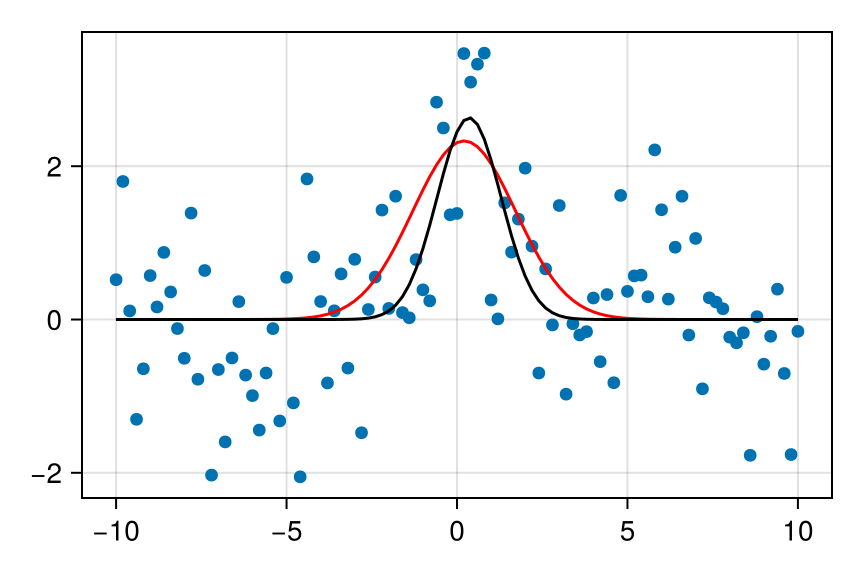

In [84]:
f = Figure(size=(6,4).*72)
ax = Axis(f[1,1])
plot!(ax, x, y)
lines!(ax, x, y_model, color=:red)
lines!(ax, x, y_fit, color=:black) 

f